In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to DB
conn = sqlite3.connect('/Users/georgepaul/Desktop/portfolio/SQL/model_data.db')  # Adjust path if needed
sns.set(style="whitegrid")

#### Preview the Table

In [3]:
df = pd.read_sql("SELECT * FROM buildings LIMIT 5;", conn)
df.head()

,EUI_kWh_per_sqmt,SQMT,NFLOOR,FLCEILHT,MONUSE,OCCUPYP,WKHRS,NWKER,HEATP,COOLP,DAYLTP,HDD65,CDD65,YRCONC,PUBCLIM
0,446.557221,19509.6300,994,12,12,100.0,70,350,100.0,100.0,0.0,4463,1759,2,3
1,194.982475,2601.2840,5,8,12,100.0,45,12,80.0,100.0,15.0,2424,189,6,4
2,226.306350,2833.5415,3,10,12,43.0,50,25,100.0,100.0,0.0,4615,1184,7,3
3,281.839592,17094.1520,3,12,12,92.0,38,400,100.0,100.0,15.0,3943,1680,2,4
4,359.900019,139354.5000,995,12,12,100.0,168,2500,98.0,98.0,0.0,5545,1262,2,7


#### Average EUI by Primary Use

/var/folders/7x/hltjgwdn7sjbwj_qq820fkkw0000gn/T/ipykernel_4168/4183926275.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=eui_by_use, x="MONUSE", y="avg_eui", palette="viridis")


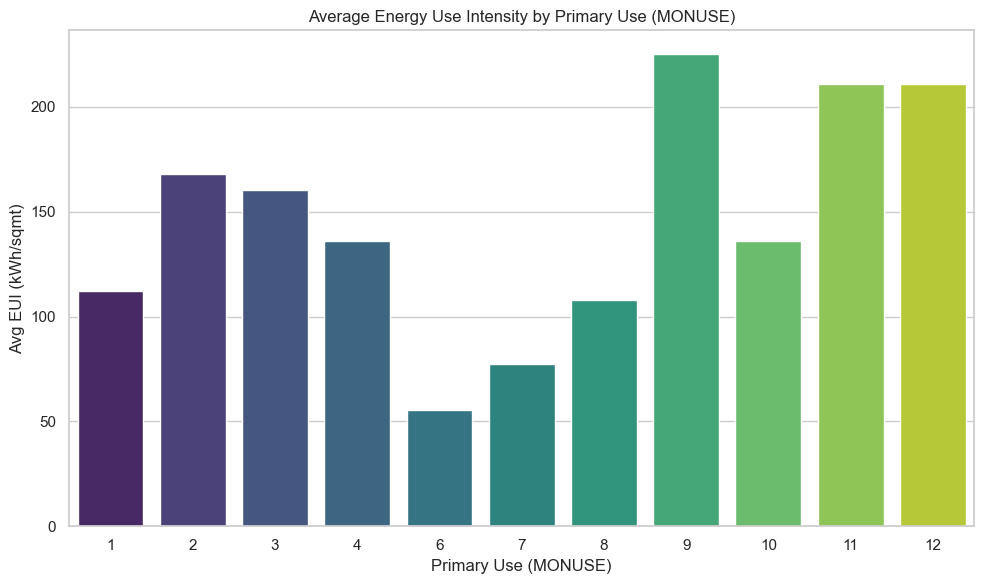

In [4]:
query = """
SELECT 
    MONUSE,
    COUNT(*) AS building_count,
    ROUND(AVG(EUI_kWh_per_sqmt), 2) AS avg_eui
FROM buildings
WHERE EUI_kWh_per_sqmt IS NOT NULL AND MONUSE IS NOT NULL
GROUP BY MONUSE
ORDER BY avg_eui;
"""

eui_by_use = pd.read_sql(query, conn)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=eui_by_use, x="MONUSE", y="avg_eui", palette="viridis")
plt.title("Average Energy Use Intensity by Primary Use (MONUSE)")
plt.xlabel("Primary Use (MONUSE)")
plt.ylabel("Avg EUI (kWh/sqmt)")
plt.tight_layout()
plt.show()

#### EUI vs. Floor Area

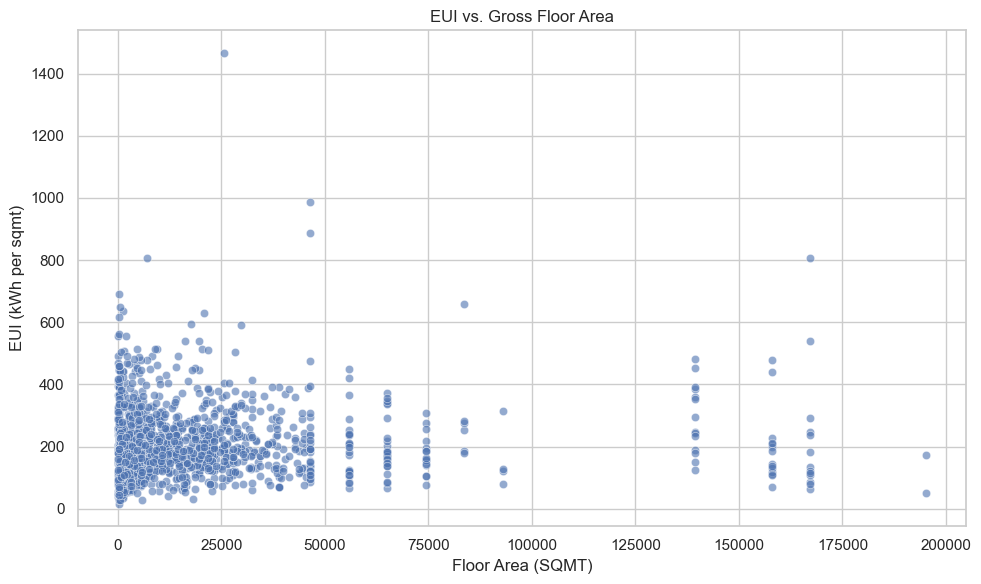

In [5]:
query = """
SELECT 
    SQMT, EUI_kWh_per_sqmt
FROM buildings
WHERE SQMT IS NOT NULL AND EUI_kWh_per_sqmt IS NOT NULL;
"""
scatter_df = pd.read_sql(query, conn)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=scatter_df, x="SQMT", y="EUI_kWh_per_sqmt", alpha=0.6)
plt.title("EUI vs. Gross Floor Area")
plt.xlabel("Floor Area (SQMT)")
plt.ylabel("EUI (kWh per sqmt)")
plt.tight_layout()
plt.show()

#### Ranking with Window Functions

In [6]:
query = """
SELECT *,
       RANK() OVER (PARTITION BY MONUSE ORDER BY EUI_kWh_per_sqmt ASC) AS efficiency_rank
FROM buildings
WHERE MONUSE IS NOT NULL AND EUI_kWh_per_sqmt IS NOT NULL
LIMIT 100;
"""
ranked = pd.read_sql(query, conn)
ranked.head()

,EUI_kWh_per_sqmt,SQMT,NFLOOR,FLCEILHT,MONUSE,OCCUPYP,WKHRS,NWKER,HEATP,COOLP,DAYLTP,HDD65,CDD65,YRCONC,PUBCLIM,efficiency_rank
0,85.728217,5202.5680,3,9,1,70.0,50,200,100.0,NaN,25.0,7162,637,9,1,1
1,138.303020,919.7397,1,10,1,90.0,40,6,75.0,75.0,30.0,3020,2253,5,4,2
2,167.967727,13192.2260,5,9,2,60.0,60,550,100.0,NaN,50.0,4149,1570,9,2,1
3,160.250542,8361.2700,3,12,3,100.0,40,240,100.0,NaN,70.0,6133,856,9,2,1
4,107.066515,4645.1500,1,20,4,33.0,40,35,33.0,NaN,2.0,7640,704,8,2,1


In [7]:
conn.close()